In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras import backend as K
from keras import optimizers

from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.losses import mean_squared_error
from keras import layers as KL

import uproot
import numpy
import matplotlib.pyplot
import pandas as pd
from pathlib import Path

from keras.layers import Input, Dense, Lambda, Layer, LeakyReLU, ReLU
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, BaseLogger, \
TerminateOnNaN, Callback, ModelCheckpoint, LambdaCallback

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

from keras.constraints import max_norm
from sklearn.externals.joblib import dump, load

from numpy.random import seed
import time

import json
import pickle
import os
import shutil

import random as rn

np.random.seed(42)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(12345)

import ray
from ray.tune.integration.keras import TuneReporterCallback
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler, ASHAScheduler, PopulationBasedTraining
import random
import csv

from config import *
from vae_utility import *

Using TensorFlow backend.
/home/roberto/anaconda3/envs/exotica_ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/roberto/anaconda3/envs/exotica_ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/roberto/anaconda3/envs/exotica_ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/h

In [2]:
original_dim = 8

latent_dim = 4
intermediate_dim = 50
kernel_max_norm = 500.
act_fun = 'relu'
weight_KL_loss = 0.6

Nf_lognorm = 6
Nf_PDgauss = 2

In [3]:
cols_ordered = ['met', 'mt', 'mbb', 'mct2',
        'mlb1', 'lep1Pt', 'nJet30', 'nBJet30_MV2c10', 'weight']

In [4]:
def KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior):
    kl_loss = K.tf.multiply(K.square(sigma), K.square(sigma_prior))
    kl_loss += K.square(K.tf.divide(mu_prior - mu, sigma_prior))
    kl_loss += K.log(K.tf.divide(sigma_prior, sigma)) -1
    return 0.5 * K.sum(kl_loss, axis=-1)

#######################################################################
def RecoProb_forVAE(x, par1, par2, par3, w):

    N = 0
    nll_loss = 0

    if Nf_lognorm != 0:

        for i in range(Nf_lognorm):

            #Log-Normal distributed variables
            mu = par1[:,i:i+1]
            sigma = par2[:,i:i+1]
            fraction = par3[:,i:i+1]
            x_clipped = K.clip(x[:,i:i+1], clip_x_to0, 1e8)
            single_NLL = K.tf.where(K.less(x[:,i:i+1], clip_x_to0),
                                    -K.log(fraction),
                                        -K.log(1-fraction)
                                        + K.log(sigma)
                                        + K.log(x_clipped)
                                        + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
            nll_loss += K.sum(w[i]*single_NLL, axis=-1)

        N += Nf_lognorm

    if Nf_PDgauss != 0:

        for i in range(N, N+Nf_PDgauss):

            mu = par1[:,i:i+1]
            sigma = par2[:,i:i+1]
            norm_xp = K.tf.divide(x[:,i:i+1] + 0.5 - mu, sigma)
            norm_xm = K.tf.divide(x[:,i:i+1] - 0.5 - mu, sigma)
            sqrt2 = 1.4142135624
            single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

            norm_0 = K.tf.divide(-0.5 - mu, sigma)
            aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
            single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

            nll_loss += K.sum(w[i]*single_NLL, axis=-1)

    return nll_loss


def IndividualRecoProb_forVAE_lognorm_1(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,:1]
    sigma = par2[:,:1]
    fraction = par3[:,:1]
    x_clipped = K.clip(x[:,:1], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,:1], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_2(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,1:2]
    sigma = par2[:,1:2]
    fraction = par3[:,1:2]
    x_clipped = K.clip(x[:,1:2], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,1:2], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_3(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,2:3]
    sigma = par2[:,2:3]
    fraction = par3[:,2:3]
    x_clipped = K.clip(x[:,2:3], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,2:3], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_4(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,3:4]
    sigma = par2[:,3:4]
    fraction = par3[:,3:4]
    x_clipped = K.clip(x[:,3:4], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,3:4], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_5(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,4:5]
    sigma = par2[:,4:5]
    fraction = par3[:,4:5]
    x_clipped = K.clip(x[:,4:5], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,4:5], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def IndividualRecoProb_forVAE_lognorm_6(x, par1, par2, par3, w):
    N = 0
    nll_loss = 0

    mu = par1[:,5:6]
    sigma = par2[:,5:6]
    fraction = par3[:,5:6]
    x_clipped = K.clip(x[:,5:6], clip_x_to0, 1e8)
    single_NLL = K.tf.where(K.less(x[:,5:6], clip_x_to0),
                            -K.log(fraction),
                                -K.log(1-fraction)
                                + K.log(sigma)
                                + K.log(x_clipped)
                                + 0.5*K.square(K.tf.divide(K.log(x_clipped) - mu, sigma)))
    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss



def individualRecoProb_forVAE_discrete_7(x, par1, par2, w):
    N = Nf_lognorm
    nll_loss = 0

    mu = par1[:,6:7]
    sigma = par2[:,6:7]
    norm_xp = K.tf.divide(x[:,6:7] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,6:7] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

def individualRecoProb_forVAE_discrete_8(x, par1, par2, w):
    N = Nf_lognorm
    nll_loss = 0

    mu = par1[:,7:8]
    sigma = par2[:,7:8]
    norm_xp = K.tf.divide(x[:,7:8] + 0.5 - mu, sigma)
    norm_xm = K.tf.divide(x[:,7:8] - 0.5 - mu, sigma)
    sqrt2 = 1.4142135624
    single_LL = 0.5*(K.tf.erf(norm_xp/sqrt2) - K.tf.erf(norm_xm/sqrt2))

    norm_0 = K.tf.divide(-0.5 - mu, sigma)
    aNorm = 1 + 0.5*(1 + K.tf.erf(norm_0/sqrt2))
    single_NLL = -K.log(K.clip(single_LL, 1e-10, 1e40)) -K.log(aNorm)

    nll_loss += K.sum(w*single_NLL, axis=-1)

    return nll_loss

In [5]:
class CustomKLLossLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomKLLossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        mu, sigma, mu_prior, sigma_prior = inputs
        return KL_loss_forVAE(mu, sigma, mu_prior, sigma_prior)
    
########################################################################
class CustomRecoProbLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomRecoProbLayer, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return RecoProb_forVAE(x, par1, par2, par3, w = w)

#################################################################################################à
class CustomIndividualLogNorLayer_1(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_1, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_1(x, par1, par2, par3, w = ind_w[0])

class CustomIndividualLogNorLayer_2(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_2, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_2(x, par1, par2, par3, w = ind_w[1])


class CustomIndividualLogNorLayer_3(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_3, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_3(x, par1, par2, par3, w = ind_w[2])

class CustomIndividualLogNorLayer_4(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_4, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_4(x, par1, par2, par3, w = ind_w[3])

class CustomIndividualLogNorLayer_5(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_5, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_5(x, par1, par2, par3, w = ind_w[4])

class CustomIndividualLogNorLayer_6(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualLogNorLayer_6, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2, par3 = inputs
        return IndividualRecoProb_forVAE_lognorm_6(x, par1, par2, par3, w = ind_w[5])

class CustomIndividualTruGauLayer_7(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualTruGauLayer_7, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2 = inputs
        return individualRecoProb_forVAE_discrete_7(x, par1, par2, w = ind_w[6])

class CustomIndividualTruGauLayer_8(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomIndividualTruGauLayer_8, self).__init__(**kwargs)

    def call(self, inputs):
        x, par1, par2 = inputs
        return individualRecoProb_forVAE_discrete_8(x, par1, par2, w = ind_w[7])

In [6]:
from keras.models import load_model
custom_objects = {
    'original_dim': 8,
    'latent_dim': latent_dim,
    'intermediate_dim': intermediate_dim,
    'act_fun': act_fun,
    'Nf_lognorm' : Nf_lognorm,
    'CustomKLLossLayer' : CustomKLLossLayer,
    'CustomRecoProbLayer' : CustomRecoProbLayer,
    
    'CustomIndividualLogNorLayer_1' : CustomIndividualLogNorLayer_1,
    'CustomIndividualLogNorLayer_2' : CustomIndividualLogNorLayer_2,
    'CustomIndividualLogNorLayer_3' : CustomIndividualLogNorLayer_3,
    'CustomIndividualLogNorLayer_4' : CustomIndividualLogNorLayer_4,
    'CustomIndividualLogNorLayer_5' : CustomIndividualLogNorLayer_5,
    'CustomIndividualLogNorLayer_6' : CustomIndividualLogNorLayer_6,
    
    'CustomIndividualTruGauLayer_7' : CustomIndividualTruGauLayer_7,
    'CustomIndividualTruGauLayer_8' : CustomIndividualTruGauLayer_8,

#     'metric' :metric,
    'IdentityLoss' : IdentityLoss
}

In [12]:
weight_KL_loss = 0.6

sig_inj='700_50'

path = 'model_results/model_dependent/bump_single_train/700_50/bump_feat_0_1_3_ld_3/autoencoder_bump_feat_5_10_0_10_0_0_0_0_ld_3.h5'
# path = 'model_results/bump_single_train/bump_feat_0_1_2_3_4_5_6_7_ld_3/vae_bump_feat_5_10_1_10_1_1_1_1_ld_3.h5'

check_vae = path.split('/')[-1]

if 'vae' in check_vae:
    print('you are loading a vae model')
elif 'autoencoder' in check_vae:
    print('pay attention, you are loading autoencoder e not vae')

with open('/'.join(path.split('/')[:-1]) + '/' + 'comps_dict.pickle', 'rb') as handle:
    components_dict = pickle.load(handle)
    
weights = []
for k,v in components_dict.items():
    weights.append(v)

if 0 in weights:
    ind_w = [x if x != 0 else 1 for x in weights]
else:
    ind_w = weights
    
# ind_w are used for uputput from 2 to 10 (for the 8 individual features)
# w are used fot the KL loss and total recon_loss
    
w = weights

pay attention, you are loading autoencoder e not vae


In [13]:
if not np.all(w): #if thera are 0's in the weights, infer components from dictionaries
    print('some zeros in the weights')
    selected_components = []
    for k,v in components_dict.items():
        if components_dict[k] != 0:
            selected_components.append(k)
    training_components = selected_components

    selected_idx = [cols.index(component) + 2  for component in selected_components]
    
else: #if w are all != 0 we need to input our selection
    selected_components = ['met', 'mt', 'mct2']
    print('no zeros in the weights') 
    selected_idx = [cols.index(component) + 2 for component in selected_components]
    
    training_components = []
    for k,v in components_dict.items():
        if components_dict[k] != 0:
            training_components.append(k)

some zeros in the weights


In [14]:
autoencoder = load_model(path, custom_objects=custom_objects)
print ('Loaded')
print("\x1b[31m model: {} trained on non-zero loss: {} \x1b[0m \n".format(path.split('/')[-1], training_components))
print("\x1b[31m total loss weights {} and individual loss weight: {} \x1b[0m \n".format(w,ind_w))
# print("\x1b[31m selected component for bump loss {} that is: {} \x1b[0m \n".format(w,ind_w))
print('selected output indexes {} (shifetd by two beacuse of model output) for the component sum that is: {}'\
      .format(selected_idx, selected_components))

Loaded
 model: autoencoder_bump_feat_5_10_0_10_0_0_0_0_ld_3.h5 trained on non-zero loss: ['met', 'mt', 'mct2']  

 total loss weights [5, 10, 0, 10, 0, 0, 0, 0] and individual loss weight: [5, 10, 1, 10, 1, 1, 1, 1]  

selected output indexes [2, 3, 5] (shifetd by two beacuse of model output) for the component sum that is: ['met', 'mt', 'mct2']


In [15]:
if path.split('/')[1] != 'model_dependent':
    
    back = np.load(train_val_test + 'background.npy')
    train = np.load(train_val_test + 'background_train.npy')
    val = np.load(train_val_test + 'background_val.npy')

    try:
        test = np.load(train_val_test + 'background_test.npy')
        split_test = 1/(len(test)/len(back))
    except:
        print('no test, tacking val')
        val = np.load(train_val_test + 'background_val.npy')

    split_train = 1/(len(train)/len(back))
    split_val = 1/(len(val)/len(back))
    print('model independent', split_test, len(test)/len(back))

    
elif path.split('/')[1] == 'model_dependent':
    
    name_sig = sig_inj

    back = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/background_sig_{}.npy'\
                   .format(name_sig, name_sig))
    train = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/background_sig_train_{}.npy'\
                    .format(name_sig, name_sig))
    val = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/background_sig_val_{}.npy'\
                  .format(name_sig, name_sig))
    try:
        test = np.load(train_val_test_mod_dep + 'bck_sig_{}_30_30_40/background_sig_test_{}.npy'\
                  .format(name_sig, name_sig))
        split_test = 1/(len(test)/len(back))
    except:
        print('no test')

    split_train = 1/(len(train)/len(back))
    split_val = 1/(len(val)/len(back))
    
    print('model dependent split test', split_test, len(test)/len(back))

model dependent split test 2.4999387530113104 0.4000097997582726


met
mt
mbb
mct2
mlb1
lep1Pt
nJet30
nBJet30_MV2c10


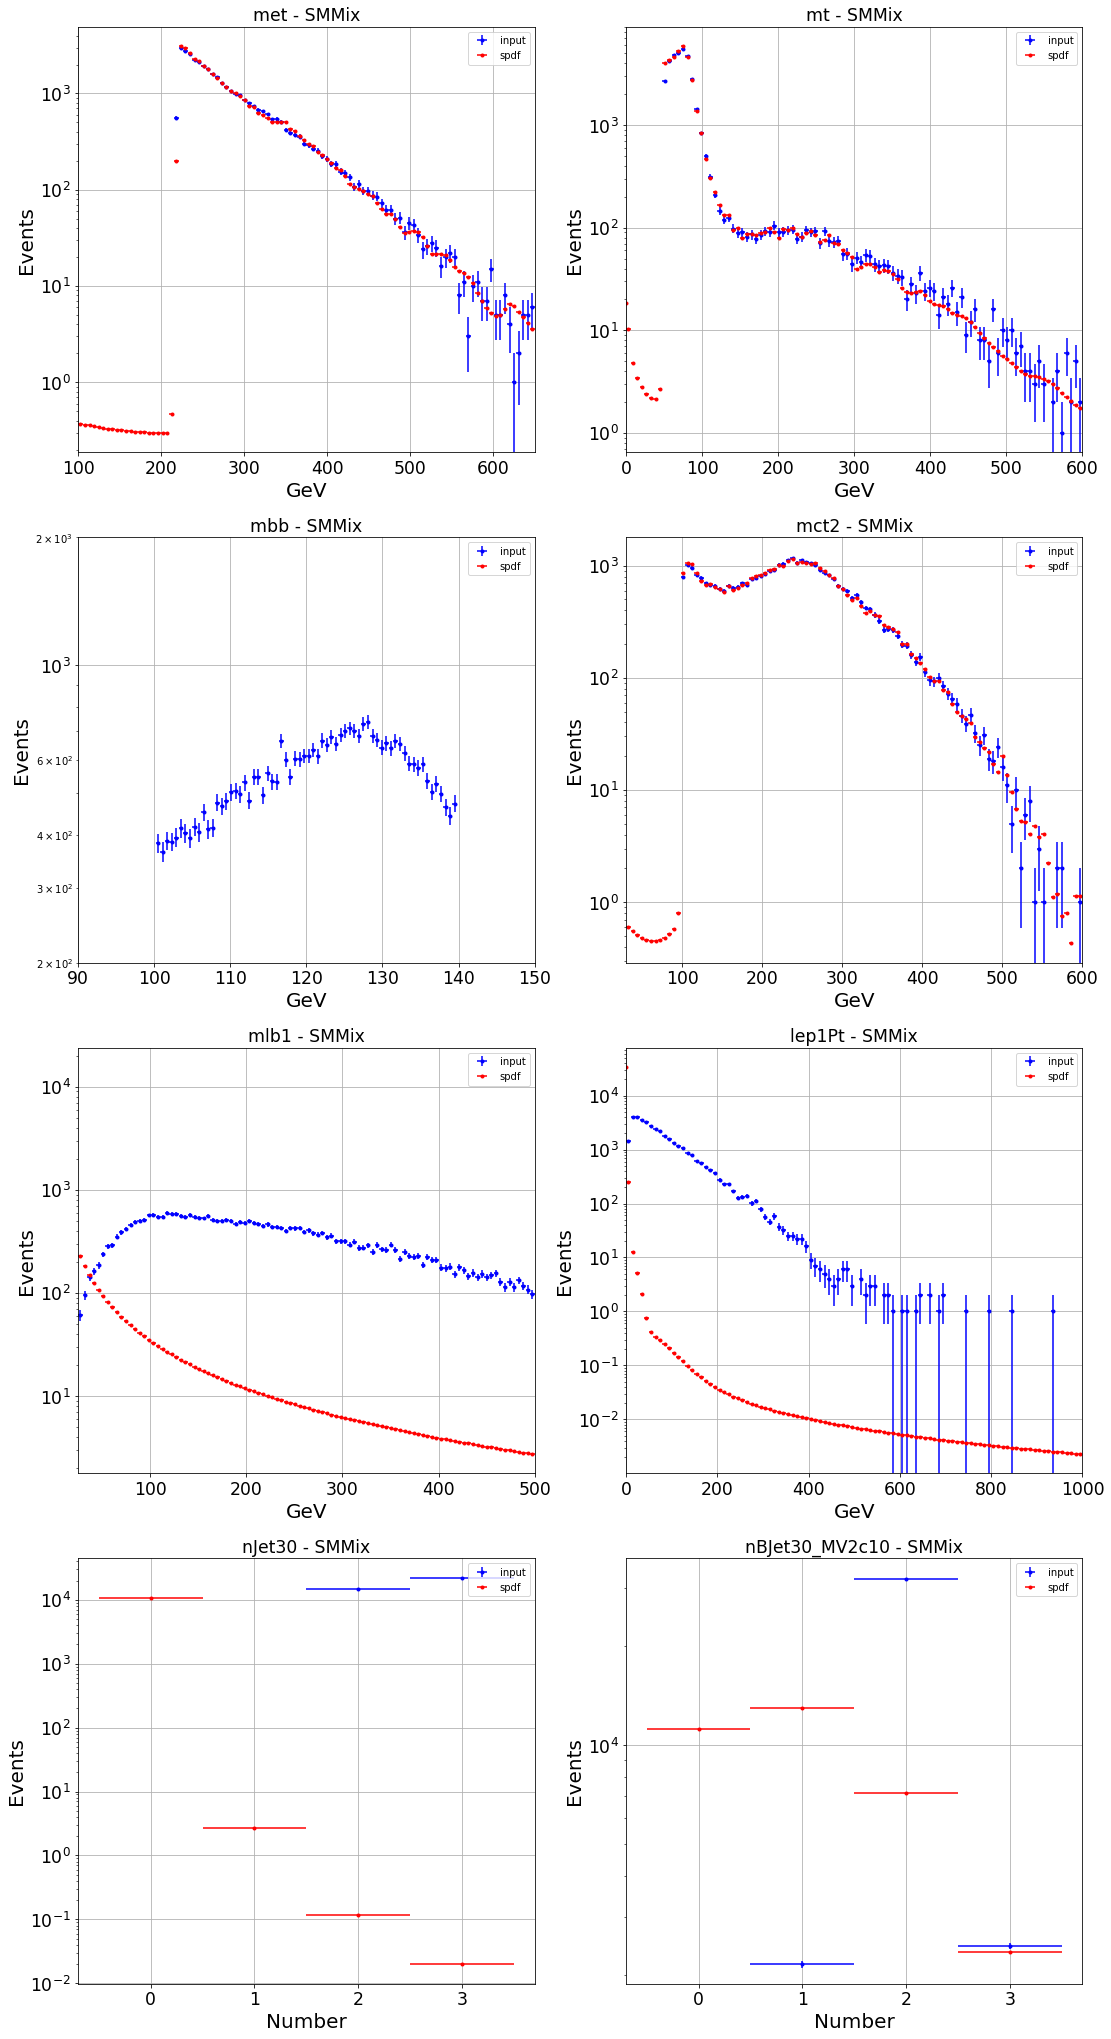

In [16]:
end = None

inputs = val[:end,:-1]
pars_ae_val = autoencoder.predict(inputs, batch_size=2000)

active_hlf_features = cols_ordered[:-1]

f, ax_arr = plt.subplots(int(len(active_hlf_features)/2.),2 , figsize=(18,36))
N_bins = 100
min_e = [100,   0,  90,   30, 25, 0, 1.5, -0.5, 0]
max_e = [650, 600, 150, 600, 500,1000, 11.5, 4.5, 18]
# bins = [20,20,20,20,20,20, 10, 5, 30]
for i,hlf_name in enumerate(active_hlf_features):
    print (hlf_name)
    
    #Plot distribution of the variable
    x_aux = val[:end, i]
    if i < Nf_lognorm:
        histo_range = (min_e[i], max_e[i])
#         histo_range = (min_e[i], max_e[i])
        bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
        if np.sum(bin_edges>clip_x_to0) > 0:
            i_aux = np.argmin(bin_edges<clip_x_to0)
            bin_edges = np.concatenate((np.array([0, clip_x_to0]), bin_edges[i_aux:]))
        else:
            bin_edges = np.array([0, clip_x_to0])
        bin_content, bin_edges = np.histogram(x_aux, bins=bin_edges, range=histo_range)
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bin_edges[1:] - bin_edges[:-1]
        bin_width[0] = 1.

        mu_vec = pars_ae_val[0][:, i]
        sigma_vec = pars_ae_val[1][:, i]
        f_vec = pars_ae_val[2][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_lognorm(bincenters, f_vec, mu_vec, sigma_vec)

    elif i < Nf_lognorm + Nf_PDgauss:
        Nmax = int(np.percentile(x_aux, 99.9))
        bin_content, bin_edges = np.histogram(x_aux, bins=Nmax+1, range=(-0.5, Nmax+0.5))
        bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
        bin_width = bincenters[1]-bincenters[0]

        mu_vec = pars_ae_val[0][:, i]
        sigma_vec = pars_ae_val[1][:, i]
        spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_PDgauss(bincenters, mu_vec, sigma_vec)        
        
#         histo_range = (np.percentile(x_aux, .1), np.percentile(x_aux, 99.9))
#         bin_content, bin_edges = np.histogram(x_aux, bins=N_bins, range=histo_range)
#         bincenters = 0.5*(bin_edges[1:]+bin_edges[:-1])
#         bin_width = bincenters[1]-bincenters[0]

#         mu_vec = pars_ae_val[0][:, i]
#         sigma_vec = pars_ae_val[1][:, i]
#         spdf_bin_content = np.sum(bin_content)*bin_width*sum_of_gaussians(bincenters, mu_vec, sigma_vec)

    if i < Nf_lognorm:
        bin_width[0] = clip_x_to0
        
        ax_arr[int(i/2), i%2].errorbar(bincenters, bin_content, xerr=bin_width/2., yerr=np.sqrt(bin_content), fmt='.b', label='input')
        ax_arr[int(i/2), i%2].errorbar(bincenters, spdf_bin_content, xerr=bin_width/2., fmt='.r', label='spdf')
        ax_arr[int(i/2), i%2].ticklabel_format(axis='y', style='sci')
        ax_arr[int(i/2), i%2].grid()
        ax_arr[int(i/2), i%2].set_title(hlf_name + ' - SMMix', size ='xx-large')        
        ax_arr[int(i/2), i%2].legend(loc='best')
        ax_arr[int(i/2), i%2].set_yscale('log')
        ax_arr[int(i/2), i%2].set_xlabel('GeV', fontsize = 20)
        ax_arr[int(i/2), i%2].set_ylabel('Events', fontsize=20)
        ax_arr[int(i/2), i%2].legend(loc='best')
        ax_arr[int(i/2), i%2].set_xlim(min_e[i], max_e[i])
        
        if i == 2:
            ax_arr[int(i/2), i%2].set_ylim(2*10**2, 2*10**3)
    
    else:
        
        ax_arr[int(i/2), i%2].errorbar(bincenters, bin_content, xerr=bin_width/2., yerr=np.sqrt(bin_content), fmt='.b', label='input')
        ax_arr[int(i/2), i%2].errorbar(bincenters, spdf_bin_content, xerr=bin_width/2., fmt='.r', label='spdf')
        ax_arr[int(i/2), i%2].ticklabel_format(axis='y', style='sci')
        ax_arr[int(i/2), i%2].grid()
        ax_arr[int(i/2), i%2].set_title(hlf_name + ' - SMMix', size ='xx-large')        
        ax_arr[int(i/2), i%2].legend(loc='best')
        ax_arr[int(i/2), i%2].set_yscale('log')
        ax_arr[int(i/2), i%2].set_xlabel('Number', fontsize = 20)
        ax_arr[int(i/2), i%2].set_ylabel('Events', fontsize=20)
        ax_arr[int(i/2), i%2].legend(loc='best')
    
    ax_arr[int(i/2), i%2].tick_params(labelsize='xx-large')        
        
plt.show() 